In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils_vug import *
import copy
import os
from sklearn.preprocessing import MinMaxScaler

In [24]:
fmi_df = pd.read_csv("fmi_array.csv")
tdep_df = pd.read_csv("tdep_array.csv")
gt = pd.read_csv("Khufai_Vugs.csv").dropna()[1:].astype('float')
well_radius_doi = pd.read_csv("well_radius_array.csv")

In [25]:
# Convert DataFrames to numpy arrays
fmi_array = fmi_df.to_numpy()
tdep_array = tdep_df .to_numpy()
well_radius_doi = well_radius_doi.to_numpy()
#print(len(fmi_array), len(tdep_array) )

In [26]:
print(well_radius_doi.shape, tdep_array.shape)

(28699, 1) (28699, 1)


In [27]:
np.shape(np.linspace(tdep_array[-1], tdep_array[0], 10).round(2))

(10, 1)

In [28]:
tdep_array= tdep_array.reshape(-1) 

Text(0.5, 1.0, 'Original')

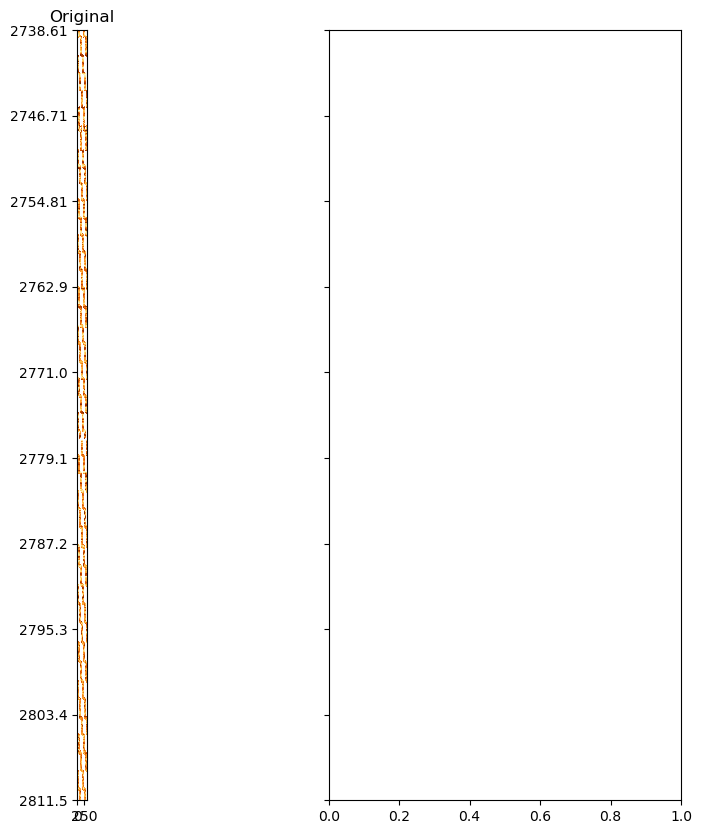

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
ax1.imshow(np.flip(fmi_array, 0), cmap="YlOrBr")
ax1.set_yticks(np.linspace(0, tdep_array.shape[0], 10), np.linspace(tdep_array[-1], tdep_array[0], 10).round(2))
ax1.invert_yaxis()
ax1.set_title("Original")

### use can imput  min_vug_area  and  min_circ_ratio in the app


In [30]:
std_thres, var_thres, skew_thres, kurt_thres = 2, 3, 5, 50
skew_thres_low, kurt_thres_low = 0.1, 1
min_high = 49
max_low = 75 #not important params
mean_low = 60

stride_mode = 5
k = 5

min_vug_area = 0.5 # Important param
max_vug_area = 10.28 #not important params
min_circ_ratio = 0.5 # Important param
max_circ_ratio = 1  #not important params

thresh_percent = 2

# c_threshold = -1
c_threshold = 'mean'

threshold_plotting = False
distribution_plot = False
area_histogram_plot = False
original_contour_plot = True
save_plot = True
greater_than_mode_percentage_plot = False
thrsholding_type = 'adaptive'
nearest_point_5 = True

if thrsholding_type == 'normal':
    std_no = 1

mean_diff_thresh = 0.1

plotting_start, plotting_end = 2637.02,2887.76


In [31]:
#tdep_array= tdep_array.reshape(-1) ##unroll to single dimension
well_radius_doi= well_radius_doi.reshape(-1)

In [32]:
stds_pos, vars_pos, skews_pos, kurts_pos = [], [], [], []
stds_neg, vars_neg, skews_neg, kurts_neg = [], [], [], []
combined_centroids, final_combined_contour, final_combined_vugs = [], [], []
pred_df = pd.DataFrame()
c = 0
height_idx = 0
start = 2739.02 # what user has start selected
end = 2810.02   # what user has end selected
contour_x, contour_y = [], []
for one_meter_zone_start in tqdm(np.arange(start,end, 1)):
    one_meter_zone_end = one_meter_zone_start + 1
#     print(one_meter_zone_start, one_meter_zone_end)
    output = get_one_meter_fmi_and_GT(one_meter_zone_start, one_meter_zone_end, 
                                      tdep_array, fmi_array, well_radius_doi, gt)
    fmi_array_one_meter_zone, tdep_array_one_meter_zone, well_radius_one_meter_zone, gtZone = output
    
    height = fmi_array_one_meter_zone.shape[0]

    different_thresholds = get_mode_of_interest_from_image(fmi_array_one_meter_zone, stride_mode, k)
    for i, diff_thresh in enumerate(different_thresholds):
        thresold_img = apply_adaptive_thresholding(fmi_array_one_meter_zone, diff_thresh, block_size = 21, c = c_threshold)
        holeR, pixLen = well_radius_one_meter_zone.mean()*100, (np.diff(tdep_array_one_meter_zone)*100).mean()
            
            # get contours and centroids from the thresholded image of the derived one meter zone
        contours, centroids, vugs = get_contours(thresold_img, depth_to=one_meter_zone_start, 
                                                     depth_from=one_meter_zone_end, radius = holeR, pix_len = pixLen, 
                                                     min_vug_area = min_vug_area, max_vug_area = max_vug_area, 
                                                     min_circ_ratio=min_circ_ratio, max_circ_ratio=max_circ_ratio) #values changed here
        output = get_combined_contours_and_centroids(contours, centroids, vugs,combined_centroids, 
                                                         final_combined_contour, final_combined_vugs,i, threshold = 5)
        combined_centroids, final_combined_contour, final_combined_vugs = output

         # filter the contours based on the contrast of each contour with the original image
        filtered_contour, filtered_vugs = filter_contours_based_on_original_image(final_combined_contour, final_combined_vugs, 
                                                                                  fmi_array_one_meter_zone, 0.2)
        # saving original filtered contour and vugs in new variable for further use
        filtered_contour_ = copy.deepcopy(filtered_contour)
        filtered_vugs_ = copy.deepcopy(filtered_vugs)

        # filter the contours based on the mean pixel in and around the original contour
        
        filtered_contour_, filtered_vugs_ = filter_contour_based_on_mean_pixel_in_and_around_original_contour(fmi_array_one_meter_zone, 
                                                                                                                filtered_contour_, 
                                                                                                                filtered_vugs_, 
                                                                                                                threshold = mean_diff_thresh)
        for pts in filtered_contour_:
            x = pts[:, 0, 0]
            y = pts[:, 0, 1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])

            y+=height_idx

            contour_x.append(x)
            contour_y.append(y)
        detected_vugs_percentage = detected_percent_vugs(filtered_contour_, fmi_array_one_meter_zone, tdep_array_one_meter_zone, 
                                                         one_meter_zone_start, one_meter_zone_end)
        pred_df = pd.concat([pred_df, detected_vugs_percentage], axis=0)
    height_idx+=height


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [01:36<00:00,  1.36s/it]


In [33]:
os.makedirs('whole', exist_ok=True)

In [34]:
vugs_threshold = 1.5
vicinity_threshold = 1
per_page_depth_zone = 10 # if selected 6m then change to 6 if 10 then change to 10 1457.8 1498.2 (1498.8)
num_rows = (vicinity_threshold*2)+1
pred_df_copy = pred_df.reset_index(drop=True)

for i in range(len(pred_df_copy)-vicinity_threshold):
    pred_df_zone = pred_df_copy.iloc[i:i+num_rows]
    idx_voi = list(pred_df_zone.index)[1]
    if pred_df_copy.iloc[idx_voi].Vugs<=vugs_threshold:
        if pred_df_zone.Vugs.max()<=vugs_threshold:
            pred_df_copy.loc[idx_voi, 'Vugs'] = 0

In [11]:
fmi_array_doi = fmi_array
tdep_array_doi = tdep_array

### More the value of per_page_depth_zone / depth selection more the time 

In [12]:
img_idx = 0
for zone_start in tqdm(np.arange(start, end, per_page_depth_zone)):
    zone_end = zone_start + per_page_depth_zone

    temp_mask = (tdep_array_doi>=zone_start) & (tdep_array_doi<=zone_end)
    fmi_zone = fmi_array_doi[temp_mask]
    pred_df_zone = pred_df_copy[(pred_df_copy.Depth>=zone_start) & (pred_df_copy.Depth<=zone_end)]
    gt_zone = gt[(gt.Depth>=zone_start) & (gt.Depth<=zone_end)]


    img_height = fmi_zone.shape[0]
    coord = [[k, j] for i, (k, j) in enumerate(zip(contour_x, contour_y)) if (j.min()>=img_idx) & (j.max()<=(img_idx+img_height))]

    _, ax = plt.subplots(1, 4, figsize=(20, 30), gridspec_kw = {'width_ratios': [3,3,1, 1], 'height_ratios': [1]})
    ax[0].imshow(fmi_zone, cmap='YlOrBr')
    ax[1].imshow(fmi_zone, cmap='YlOrBr')
    for x_, y_ in coord:
        centroid_y = get_centeroid(np.concatenate([x_.reshape(-1, 1), (y_-img_idx).reshape(-1, 1)], axis=1))[1]
        scaler = MinMaxScaler((zone_start, zone_end))
        scaler.fit([[0], [img_height]])
        centroid_depth = scaler.transform([[centroid_y]])[0][0]

        depth_values, target_value = pred_df_zone.Depth.values, centroid_depth

        # Find the index where the target_value should be inserted
        insert_index = np.searchsorted(depth_values, target_value, side='right') - 1

        # Check if the target_value is greater than the last depth value, in that case, it will be inserted at the end
        if insert_index == len(depth_values) - 1 and target_value > depth_values[-1]:
            insert_index = len(depth_values) - 1
        if pred_df_zone.iloc[insert_index].Vugs != 0:
            ax[1].plot(x_, y_-img_idx, color='black', linewidth=2)

    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    plot_barh(ax[2], pred_df_zone.Depth.values, pred_df_zone['Vugs'].values, 
                  zone_start, zone_end-0.1, "Pred\n0-25%", max_scale=25, fontsize = 12)
        
    plot_barh(ax[3], gt_zone.Depth.values, gt_zone['Vugs'].values, 
                  zone_start, zone_end-0.1, "GT\n0-25%", max_scale=25, fontsize = 12)
    
    ax[0].set_title("Original FMI", fontsize=12)
    ax[1].set_title("Contours", fontsize=12)

    plt.tight_layout()
    plt.savefig(f"whole/{zone_start}.png", dpi=400, bbox_inches='tight')
    plt.close()
    # break
    img_idx+=img_height
    # if img_idx>=5000:
    #     break

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:43<00:00, 35.40s/it]
